In [1]:
import torch 
import torchvision 
import numpy as np

import os
import pandas as pd
import albumentations as A
import albumentations.pytorch
import cv2

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
# import torch.nn.functional as F

import sys
sys.path.append('../')
from dataset import val_transforms, CDataset

In [2]:
import easydict 
args = easydict.EasyDict({ "batch_size": 256, 
                          "epochs": 30, 
                          "data": 0, 
                          'lr':0.1,
                         'momentum':0.9,
                         'weight_decay':1e-4,
                         'start_epoch':0,
                         'gpu':0,
                          'workers':8,
                         'print_freq':2000,
                          'ratio':0.2,
                         'saved_dir':'../trained_models/resnet/checkpoint.pt'})

In [3]:
# make saved dir
from pathlib import Path
path = Path(args.saved_dir.split('checkpoint')[0])
path.mkdir(parents=True, exist_ok=True)

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "2"  # Set the GPUs 2 and 3 to use

In [5]:
ngpus_per_node = torch.cuda.device_count()
print(ngpus_per_node)
# device = torch.device('cpu')
# device = torch.device('cuda')
GPU_NUM = args.gpu # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
print(device)

1
cuda:0


In [6]:
IMAGE_SIZE = 256
from augment import HEColorAugment
train_transforms = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE, p=1),
    A.OneOf([
        A.HorizontalFlip(p=.8),
        A.VerticalFlip(p=.8),
        A.RandomRotate90(p=.8)]
    ),
#     A.RandomResizedCrop(height=IMAGE_SIZE,width=IMAGE_SIZE,scale=[0.95,1.05],ratio=[0.95,1.05],p=0.5),
    A.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=.8),
#     HEColorAugment(sigma1=0.2, sigma2=.2, theta1=1., theta2=1., theta3=1., p=.8),
], p=1.0) 

In [7]:
import albumentations as A
import albumentations.pytorch
import cv2
from augment import HEColorAugment, rgb_to_sda

class CDataset(Dataset):
    def __init__(self, df, defaultpath='/home/beomgon/Dataset/new_patches/', transform=None):
        self.df = df
        self.transform = transform
        self.dir = defaultpath

    def __len__(self):
        return len(self.df)   

    def __getitem__(self, idx):
        path = self.df.iloc[idx, 4]
#         print(pid)

        image = cv2.imread(self.dir + path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = (image.astype(np.float32)-128.)/128.
        
#         if image is uint8, normalization by 255 is done automatically by albumebtation(ToTensor method)
        if self.transform:
            timage = self.transform(image=image)
            image = timage['image']
            
#         image = rgb_to_sda(image)
        
        image =  torch.tensor(image, dtype=torch.float32)/255.
        #image = (torch.tensor(image, dtype=torch.float32)-128)/128
        image = image.permute(2,0,1)
            
        label = self.df.iloc[idx, 5]
        return image, label, path

In [8]:
train_df = pd.read_csv('../dataframe/train_New_Stomach_df.csv')
train_dataset = CDataset(train_df, defaultpath='/home/beomgon/pytorch/seegene/new_patches/', 
                         transform=train_transforms)

val_df = pd.read_csv('../dataframe/val_New_Stomach_df.csv')
val_dataset = CDataset(val_df, defaultpath='/home/beomgon/pytorch/seegene/new_patches/',
                       transform=val_transforms)  

test_df = pd.read_csv('../dataframe/test_New_Stomach_df.csv')
test_dataset = CDataset(test_df, defaultpath='/home/beomgon/pytorch/seegene/new_patches/',
                        transform=val_transforms)

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(75782, 6)
(25961, 6)
(15119, 6)


In [9]:
image, label, path = next(iter(train_dataset))
# image

In [10]:
train_loader = DataLoader(train_dataset, batch_size=args.batch_size,
                          shuffle=True, num_workers=args.workers)

val_loader = DataLoader(val_dataset, batch_size=args.batch_size,
                          shuffle=True, num_workers=args.workers)

test_loader = DataLoader(test_dataset, batch_size=args.batch_size,
                          shuffle=True, num_workers=args.workers)


In [11]:
images, labels, paths = next(iter(train_loader))
images.shape

torch.Size([256, 3, 256, 256])

In [12]:
import torchvision.models as models
model = models.resnet18(pretrained=True)
# model = models.densenet201(pretrained=True)
# model.fc.out_features = 3
model.fc = nn.Linear(512, 3)
default_state_dict = model.state_dict()
# model = nn.DataParallel(model)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.Adam(params, lr=0.01)
optimizer = torch.optim.SGD(
       params, lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
# optimizer = torch.optim.SGD(params, lr=args.lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15, 20, 25, 30], 
                                                    gamma=0.2)
# criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
criterion = nn.CrossEntropyLoss().to(device)

In [13]:
torch.abs(torch.matmul(model.fc.weight, model.fc.weight.T) - 0.3*torch.eye(3, device='cuda')).mean()
# torch.abs(torch.matmul(model.module.fc.weight, model.module.fc.weight.T) - 0.3*torch.eye(3, device='cuda')).mean()

tensor(0.0178, device='cuda:0', grad_fn=<MeanBackward0>)

In [14]:
torch.matmul(model.fc.weight, model.fc.weight.T) - 0.3*torch.eye(3, device='cuda')
# torch.matmul(model.module.fc.weight, model.module.fc.weight.T) - 0.3*torch.eye(3, device='cuda')

tensor([[ 0.0367, -0.0041,  0.0193],
        [-0.0041,  0.0313, -0.0061],
        [ 0.0193, -0.0061,  0.0330]], device='cuda:0', grad_fn=<SubBackward0>)

In [15]:
from main import *

In [16]:
ratio = [0., 0.02, 0.04, 0.08, 0.2, 0.4]
acc_list = []
test_acc = []

for num in range(len(ratio)) :
    args.saved_dir = '../trained_models/resnet/hsv/stomach2_' + str(num) + '/checkpoint.pt'
    path = Path(args.saved_dir.split('checkpoint')[0])
    path.mkdir(parents=True, exist_ok=True)  
#     args.ratio = ratio[num]
    
    train_transforms = A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE, p=1),
        A.OneOf([
            A.HorizontalFlip(p=.8),
            A.VerticalFlip(p=.8),
            A.RandomRotate90(p=.8)]
        ),
    #     A.RandomResizedCrop(height=IMAGE_SIZE,width=IMAGE_SIZE,scale=[0.95,1.05],ratio=[0.95,1.05],p=0.5),
        A.transforms.ColorJitter(brightness=ratio[num], contrast=ratio[num], saturation=ratio[num], hue=ratio[num], p=.8),
    #     HEColorAugment(sigma1=0.2, sigma2=.2, theta1=1., theta2=1., theta3=1., p=.8),
    ], p=1.0)     
    
    model = models.resnet18(pretrained=True)
    # model.fc.out_features = 3
    model.fc = nn.Linear(512, 3)
#     model = nn.DataParallel(model)
    model.load_state_dict(default_state_dict)
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
#     optimizer = torch.optim.Adam(params, lr=0.01)
    optimizer = torch.optim.SGD(
           params, lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15, 20, 25, 30], 
                                                        gamma=0.2)
    # criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
    criterion = nn.CrossEntropyLoss().to(device)
    # print(model.fc.weight.shape)    
    
    best_acc1 = 0
    acc1 = 0
    train_loss = []
    val_acc = []

    for epoch in range(args.epochs):
        losses = train(train_loader, model, criterion, optimizer, epoch, args)
        scheduler.step()

        # evaluate after every epoch
        acc1 = validate(val_loader, model, criterion, args)   
        val_acc.append(acc1.item())

        # remember best acc@1 and save checkpoint
        is_best = acc1 > best_acc1
        best_acc1 = max(acc1, best_acc1) 

        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_acc1': best_acc1,
            'optimizer' : optimizer.state_dict(),
            'scheduler' : scheduler.state_dict(),
        }, is_best, filename=args.saved_dir)   
        
    checkpoint = torch.load(args.saved_dir)
    model.load_state_dict(checkpoint['state_dict'])
    acc1 = validate(test_loader, model, criterion, args)    
    print('************* test number {} ratio {} acc{} *************'.format(num, ratio[num], acc1))    
    acc_list.append(val_acc)    
    test_acc.append(acc1)
    

Epoch: [0][  0/297]	Time  5.370 ( 5.370)	Data  4.102 ( 4.102)	Loss 1.1143e+00 (1.1143e+00)	Acc@1  37.11 ( 37.11)
Test: [  0/102]	Time  2.047 ( 2.047)	Loss 1.1603e+00 (1.1603e+00)	Acc@1  41.02 ( 41.02)
 * Acc@1 42.009
Epoch: [1][  0/297]	Time  3.211 ( 3.211)	Data  2.953 ( 2.953)	Loss 1.3727e+00 (1.3727e+00)	Acc@1  31.64 ( 31.64)
Test: [  0/102]	Time  3.689 ( 3.689)	Loss 1.2078e+00 (1.2078e+00)	Acc@1  43.75 ( 43.75)
 * Acc@1 40.295
Epoch: [2][  0/297]	Time  2.083 ( 2.083)	Data  1.871 ( 1.871)	Loss 1.0478e+00 (1.0478e+00)	Acc@1  42.19 ( 42.19)
Test: [  0/102]	Time  3.631 ( 3.631)	Loss 1.4520e+00 (1.4520e+00)	Acc@1  48.83 ( 48.83)
 * Acc@1 44.451
Epoch: [3][  0/297]	Time  4.229 ( 4.229)	Data  3.963 ( 3.963)	Loss 1.0972e+00 (1.0972e+00)	Acc@1  41.02 ( 41.02)
Test: [  0/102]	Time  3.571 ( 3.571)	Loss 1.0532e+00 (1.0532e+00)	Acc@1  42.97 ( 42.97)
 * Acc@1 41.397
Epoch: [4][  0/297]	Time  4.186 ( 4.186)	Data  3.936 ( 3.936)	Loss 1.0968e+00 (1.0968e+00)	Acc@1  39.45 ( 39.45)
Test: [  0/102]	Tim

[0.0, 0.02, 0.04, 0.08, 0.2, 0.4]


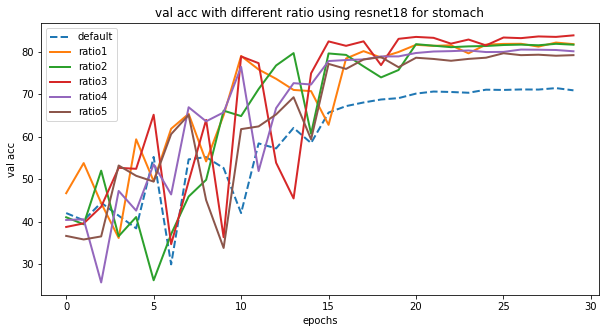

[tensor(75.0446, device='cuda:0'), tensor(84.9792, device='cuda:0'), tensor(85.2702, device='cuda:0'), tensor(86.3549, device='cuda:0'), tensor(82.4459, device='cuda:0'), tensor(82.2607, device='cuda:0')]


In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs = range(args.epochs)
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['lines.linewidth'] = 2
plt.plot(epochs, acc_list[0], linestyle='--')
plt.plot(epochs, acc_list[1])
plt.plot(epochs, acc_list[2])
plt.plot(epochs, acc_list[3])
plt.plot(epochs, acc_list[4])
plt.plot(epochs, acc_list[5])
plt.legend(['default', 'ratio1', 'ratio2', 'ratio3', 'ratio4', 'ratio5'])
plt.xlabel('epochs')
plt.ylabel('val acc')
plt.title('val acc with different ratio using resnet18 for stomach')
print(ratio)
# plt.axis([10, 30, 88, 94])
plt.show()
print(test_acc)

In [18]:
for i in acc_list :
    print(i)

[42.0091667175293, 40.2950553894043, 44.451290130615234, 41.39670944213867, 38.411460876464844, 55.22899627685547, 29.929508209228516, 54.64735412597656, 55.18277359008789, 52.59812545776367, 42.005313873291016, 58.406837463378906, 57.2281494140625, 62.05461883544922, 58.49543380737305, 65.66387939453125, 67.18539428710938, 68.04051971435547, 68.74156951904297, 69.06513214111328, 70.13211822509766, 70.61360931396484, 70.50960540771484, 70.32856750488281, 71.052734375, 70.99109649658203, 71.10665893554688, 71.07969665527344, 71.42251586914062, 70.89865112304688]
[46.68540954589844, 53.776817321777344, 44.3549919128418, 36.14652633666992, 59.36982345581055, 49.49732208251953, 61.862022399902344, 65.36727905273438, 54.165863037109375, 65.04756927490234, 78.98385620117188, 75.80986785888672, 73.61426544189453, 70.99109649658203, 70.70990753173828, 62.77107620239258, 78.39451599121094, 80.12403106689453, 78.61792755126953, 79.9237289428711, 81.61087799072266, 81.36820220947266, 81.506874084